# Capstone Project

### IBM Data Science Professional Certificate

##### Libraries and dependencies

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import math
import requests
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import DBSCAN 
import matplotlib.cm as cm
import matplotlib.colors as colors
! pip install folium==0.5.0
import folium
from scipy import cluster
from matplotlib import pyplot as plt
! pip install yellowbrick
from numpy import unique
from numpy import where
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm
from sklearn.neighbors import DistanceMetric
import seaborn as sn
import matplotlib.pyplot as plt

##### Import cities and filter them based on population data

In [2]:
# import coordinates of relevnat cities all around the world
coordinates_list = pd.read_csv (r'C:\Users\m.lanzoni\Desktop\worldcities.csv')

# transforming the list into a dataframe
df_coordinates = pd.DataFrame(coordinates_list)

# keeping only a subset of cities 
df_coordinates = df_coordinates.drop(df_coordinates[df_coordinates['Y/N']!='Y'].index)
df_coordinates = df_coordinates.drop(df_coordinates[df_coordinates['country']=='China'].index)
df_coordinates = df_coordinates[df_coordinates['population'].notna()]
df_coordinates = df_coordinates.drop(df_coordinates[df_coordinates['population']<2500000].index)

# removing unnecessary columns
columns = ['city_ascii','iso2','iso3', 'admin_name', 'capital', 'id', 'population', 'Y/N','country']
df_coordinates.drop(columns, axis=1, inplace=True)

# renaming columns
df_coordinates.rename(columns={'city':'City', 'lat':'Latitude', 'lng':'Longitude' }, inplace=True)
cities_all = df_coordinates

# show how many cities are left after filtering and show them 
print ('The number of cities satisfying the requirements is ' + str(cities_all.shape[0]))
cities_all

The number of cities satisfying the requirements is 36


,City,Latitude,Longitude
0,Tokyo,35.6897,139.6922
12,New York,40.6943,-73.9249
14,Moscow,55.7558,37.6178
21,Ōsaka,34.6936,135.5019
27,Los Angeles,34.1139,-118.4068
33,Paris,48.8566,2.3522
34,London,51.5072,-0.1275
44,Nagoya,35.1167,136.9333
49,Chicago,41.8373,-87.6862
66,Hong Kong,22.3050,114.1850


##### Parameters to be used by Foursquare's APIS

In [3]:
# setting parameters 

CLIENT_ID = 'KUSVPIIUTCEM3NXUKNJQ1DFEN0TM1PLZUHFZOHICNYXNFVSG' # your Foursquare ID
CLIENT_SECRET = '0BVFO2KRHMJU2A3VV5BURZ4XGDFJJGZKUBNJ0RF5OCH4IV04' # your Foursquare Secret
ACCESS_TOKEN = 'LJ34UGQIQSGLYSD2B1MUP5PI4IHWT2FQH5PNMMF4PO0XQNFQ' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 700 # meters around the center of a city
MINVENUES = 40 # minimum number of categories to keep a city
CATEGORYID = '4d4b7105d754a06374d81259' # Food = 4d4b7105d754a06374d81259 - Arts & Entertainment = 4d4b7104d754a06370d81259

##### Get the hierachical structure os venues categories in order to tanscode each actual category to its 2nd level parent 

In [4]:
# build the FourSquare url to get all the categories 
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            LIMIT)
results = requests.get(url).json()["response"]['categories']


# scan the json file to get the categories tree
tree_list = []
for l1 in range(len(results)):
    for l2 in range(len(results[l1]['categories'])):
        for l3 in range(len(results[l1]['categories'][l2]['categories'])):
            tree_list.append([results[l1]['name'],results[l1]['categories'][l2]['name'],results[l1]['categories'][l2]['categories'][l3]['name']])
            for l4 in range(len(results[l1]['categories'][l2]['categories'][l3]['categories'])):
                tree_list.append([results[l1]['name'],results[l1]['categories'][l2]['name'],results[l1]['categories'][l2]['categories'][l3]['name'],results[l1]['categories'][l2]['categories'][l3]['categories'][l4]['name']])
                for l5 in range(len(results[l1]['categories'][l2]['categories'][l3]['categories'][l4]['categories'])):
                    tree_list.append([results[l1]['name'],results[l1]['categories'][l2]['name'],results[l1]['categories'][l2]['categories'][l3]['name'],results[l1]['categories'][l2]['categories'][l3]['categories'][l4]['name'],results[l1]['categories'][l2]['categories'][l3]['categories'][l4]['categories'][l5]['name']])
                    
# convert tree_list into a dataframe
tree_df = pd.DataFrame(tree_list, columns = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5']) 

# build a dataframe listing all categories (from all the level of the tree) and their 2nd parent level
categories_list = []
for i in range(tree_df.shape[0]):
    categories_list.append([tree_df['Level2'][i],tree_df['Level2'][i]])
for i in range(tree_df.shape[0]):
    categories_list.append([tree_df['Level2'][i],tree_df['Level3'][i]])
for i in range(tree_df.shape[0]):
    categories_list.append([tree_df['Level2'][i],tree_df['Level4'][i]])
for i in range(tree_df.shape[0]):
    categories_list.append([tree_df['Level2'][i],tree_df['Level5'][i]])

# convert categories_list into a dataframe
categories = pd.DataFrame(categories_list, columns = ['Category', 'Venue Category']).dropna(axis=0).reset_index()

##### Function to be used for looping on Foursqaure's API over cities

In [5]:
# define a function which calls FourSquare APIs and parse the result

def getCityVenues(names, latitudes, longitudes, radius = RADIUS):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            CATEGORYID,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']  
            , v['venue']['categories'][0]['name']
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',           
                  'Venue Category']
    
    return(nearby_venues)

##### Loop on Foursqaure's API over cities

In [9]:
# run the function 'getCityVenues' on all the cities previously selected
cities_venues_all = getCityVenues(names=cities_all['City'],
                                  latitudes=cities_all['Latitude'],
                                  longitudes=cities_all['Longitude']
                                 )

Tokyo
New York
Moscow
Ōsaka
Los Angeles
Paris
London
Nagoya
Chicago
Hong Kong
Miami
Dallas
Philadelphia
Houston
Atlanta
Toronto
Washington
Saint Petersburg
Boston
Barcelona
Phoenix
Seattle
Yokohama
Berlin
San Francisco
Montréal
Detroit
Madrid
San Diego
Minneapolis
Tampa
Birmingham
Denver
Rome
Manchester
Brooklyn


##### Drop cities with too few venues

In [141]:
# group venues by city and show the number of venues per city
df = cities_venues_all.groupby('City').count().reset_index()
df[['City','Venue']].sort_values(by=['Venue'], ascending=False)

# build a dummy dataframe with rows to drop (cities with less than MINVENUES venues)
df = df[df['Venue Category'] < MINVENUES]

# keep only cities with at least MINVENUES venues, both on cities_venues and cities dataframes
cities_venues = cities_venues_all
cities = cities_all
for i in range(0,df.shape[0]):
    cities_venues = cities_venues.drop(cities_venues[cities_venues.City == df.City[df.index[i]]].index)
    cities = cities.drop(cities[cities.City == df.City[df.index[i]]].index)

##### Check that different dataframes get the same entries after dropping

In [142]:
# just a quick consistency check about numbers
print ('The initial number of cities is ' + str(cities_all.shape[0]))
print ('The number of cities with not enough venues is ' + str(df.shape[0]))
print ('The number of cities remaining after dropping is ' + str(cities.shape[0]))
if (cities_all.shape[0]-df.shape[0]==cities.shape[0]):
    print ('Everything seems OK')
else:
    print ('Something is wrong!')

The initial number of cities is 36
The number of cities with not enough venues is 17
The number of cities remaining after dropping is 19
Everything seems OK


##### Merge two dataframe to add location data to the venues dataframe 

In [143]:
# create a dataframe by left-joining cities_venues and cities locations
left_merged = pd.merge(cities_venues, categories, how="left", on=["Venue Category"])

##### Clean-up the resulting dataframe (drop and rename columns, remove NA)

In [144]:
# drop unrequested columns form the previous dataframe
columns = ['Venue Category','index']
left_merged.drop(columns, axis=1, inplace=True)

# rename the column Category into Venue Category
left_merged.rename(columns = {'Category': 'Venue Category'}, inplace = True)

# rename dataframe as cities_venues
cities_venues = left_merged

# drop rows with NA and rebuild index 
cities_venues = cities_venues.dropna(axis=0).reset_index()

##### One-hot encoding to change the structure of the dataset (we nee one city per row)

In [145]:
# one hot encoding of Venue Category
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to the dataframe
cities_onehot['City'] = cities_venues['City'] 

# move City column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

# mean of the occurrence frequency of each category
cities_grouped = cities_onehot.groupby('City').mean().reset_index()

# drop column City to have only features
cities_grouped_clustering = cities_grouped.drop('City', 1)

##### Data exploration

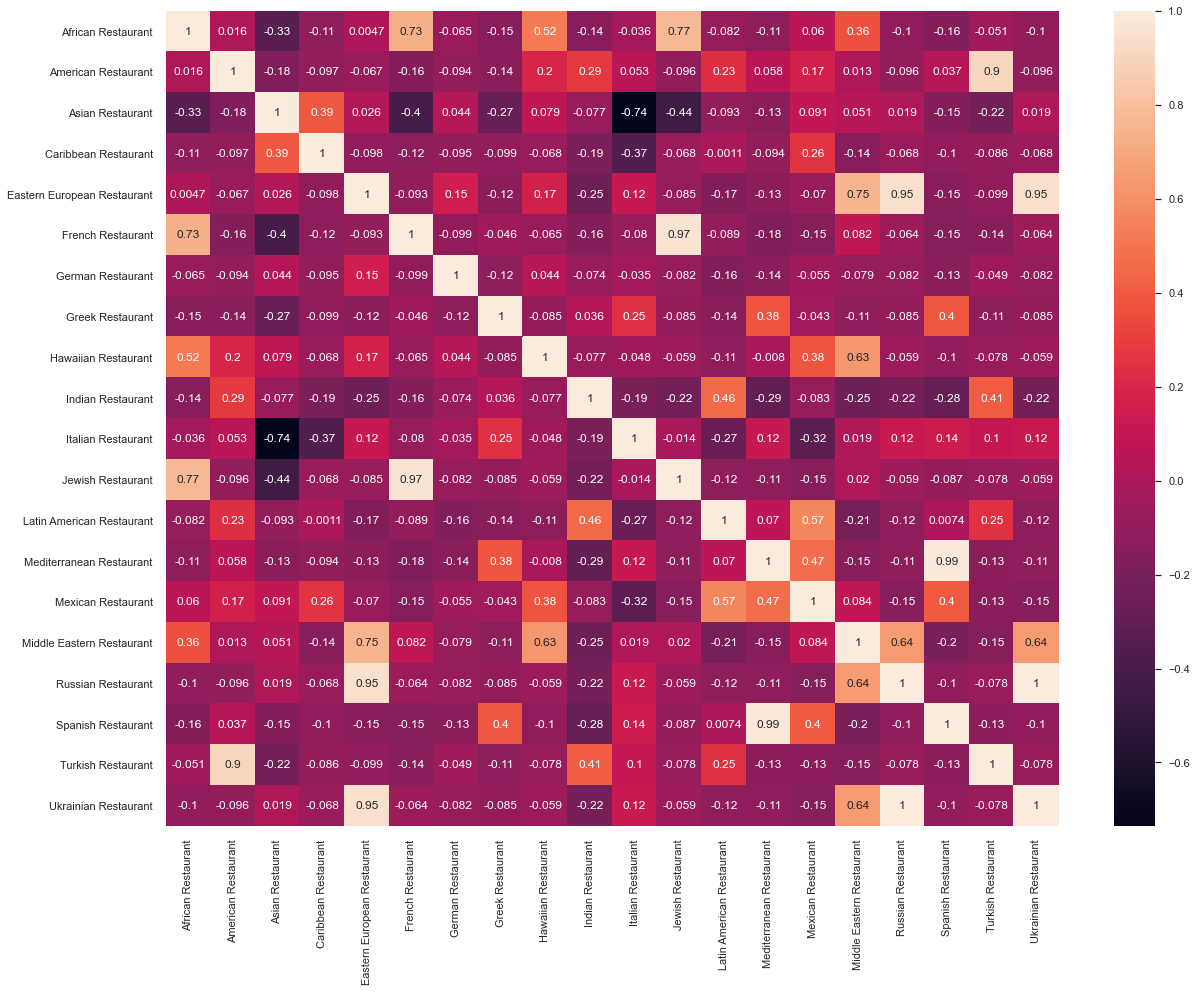

In [146]:
# find correlations

# build the correlation matrix
corrMatrix = cities_grouped_clustering.corr()

# set figure dimensions and build the heatplot of the correlation matrix
plt.subplots(figsize=(20,15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

##### Boxplot of the complete set of features

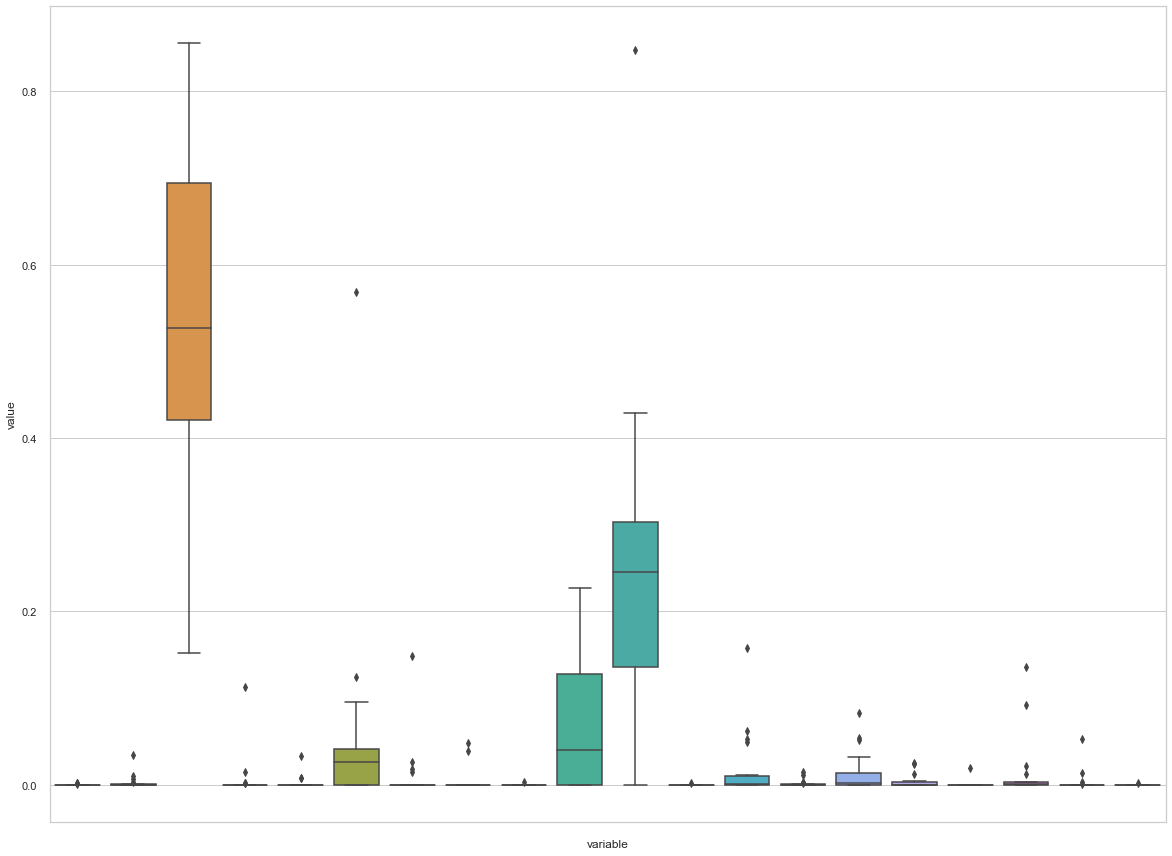

In [153]:
# Variance analysis

# build a box-plot of all features
plt.subplots(figsize=(20,15))
sn.boxplot(x="variable", y="value", data=pd.melt(cities_grouped_clustering)).set(xticklabels=[])
plt.show()

##### Boxplot of the features with mean occurrence greater than 0.01

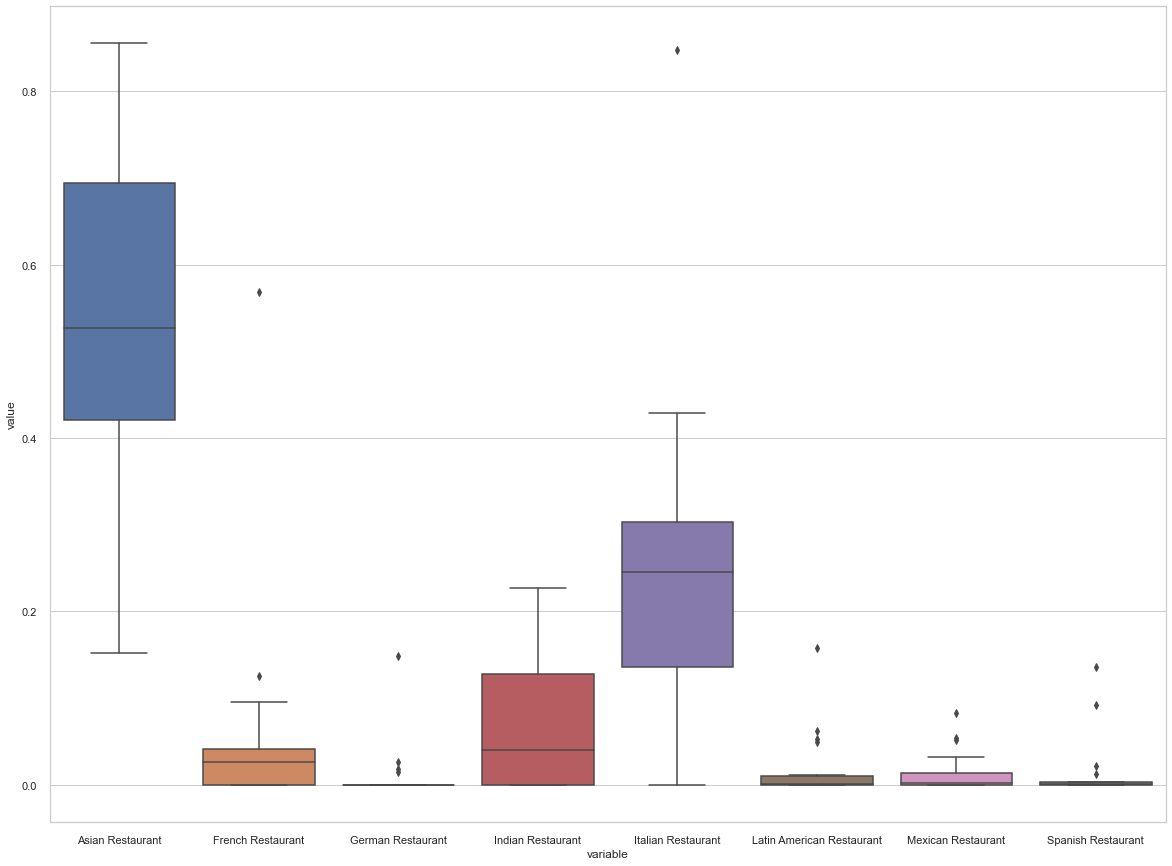

In [155]:
df_restricted = cities_grouped_clustering[cities_grouped_clustering.columns[cities_grouped_clustering.mean(axis = 0) > 0.01]]
plt.subplots(figsize=(20,15))
sn.boxplot(x="variable", y="value", data=pd.melt(df_restricted))
plt.show()

##### Save to file the statistics of the reduced set of features

In [172]:
# Variance analysis

# export to csv the statistics of the selected features 
cities_grouped_clustering = df_restricted
cities_grouped_clustering.describe().to_csv("describe.csv")

##### Elbow method applied to K-means algorithm to find the best value for the number of clusters. Loop over metrics: distortion, ilhouette and calinski_harabasz

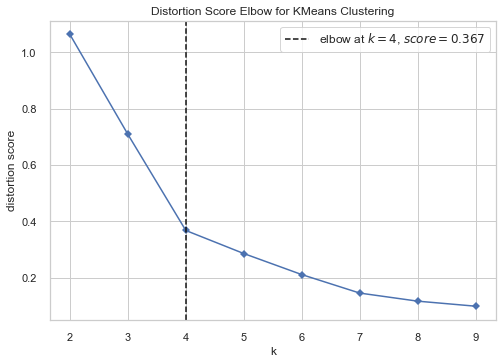

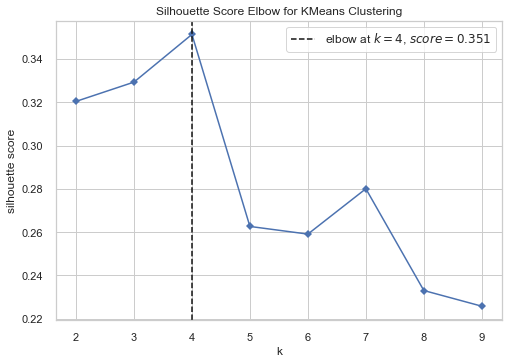

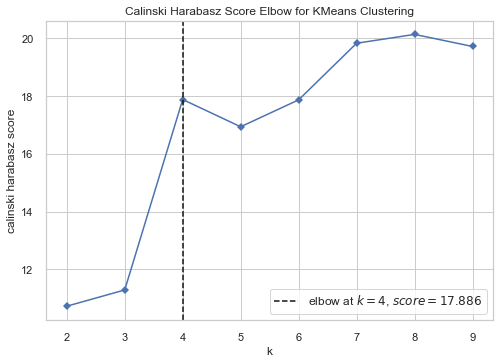

In [160]:
# Use KElbowVisualizer to get the optimal number of clusters by fitting the model with a range of values for K

# Setting the list with the metrics to be used
metric_list = ['distortion','silhouette','calinski_harabasz']

# Loop over metric_list applyng K-means model
for metric_item in metric_list:
    # Instantiate the clustering model and visualizer
    model = KMeans()
    visualizer = KElbowVisualizer(
        model, k=(2,10), metric=metric_item, timings=False
    )

    visualizer.fit(cities_grouped_clustering)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

##### Elbow method applied to Agglomerative algorithm to find the best value for the number of clusters. Loop over metrics: distortion, ilhouette and calinski_harabasz

In [ ]:
# Use KElbowVisualizer to get the optimal number of clusters by fitting the model with a range of values for K

# Setting the list with the metrics to be used
metric_list = ['distortion','silhouette','calinski_harabasz']

# Loop over metric_list applyng agglomerative model
for metric_item in metric_list:
    # Instantiate the clustering model and visualizer
    model = AgglomerativeClustering()
    visualizer = KElbowVisualizer(
        model, k=(2,10), metric=metric_item, timings=False
    )

    visualizer.fit(cities_grouped_clustering)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

##### Run K-mean algorithm (with k = 4 as number of clusters) and print Silhouette, Calinski Harabasz and Davies Bouldin scores.

In [165]:
# run K means algorithm

# best k from previous tests
kmeans_n_clusters = 4

# Fit K-Means
kmeans = KMeans(n_clusters = kmeans_n_clusters, random_state= 10)

# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(cities_grouped_clustering)

# Calculate cluster validation metrics
score_kemans_s = silhouette_score(cities_grouped_clustering, kmeans.labels_, metric='euclidean')
score_kemans_c = calinski_harabasz_score(cities_grouped_clustering, kmeans.labels_)
score_kemans_d = davies_bouldin_score(cities_grouped_clustering, predictions)

print('Silhouette Score: %.4f' % score_kemans_s)
print('Calinski Harabasz Score: %.4f' % score_kemans_c)
print('Davies Bouldin Score: %.4f' % score_kemans_d)

Silhouette Score: 0.3514
Calinski Harabasz Score: 17.8863
Davies Bouldin Score: 0.5610


##### Run Agglomerative algorithm (with k = 4 as number of clusters) and print Silhouette, Calinski Harabasz and Davies Bouldin scores.

In [166]:
# run Agglomerative algorithm

# best k from previous tests
agglom_n_clusters = 4

# define the model
agglom = AgglomerativeClustering(n_clusters = agglom_n_clusters)
# fit model and predict clusters
yhat = agglom.fit(cities_grouped_clustering)
yhat_2 = agglom.fit_predict(cities_grouped_clustering)
# retrieve unique clusters
clusters = unique(yhat)

# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(cities_grouped_clustering, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(cities_grouped_clustering, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(cities_grouped_clustering, yhat_2)

print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.3514
Calinski Harabasz Score: 17.8863
Davies Bouldin Score: 0.5610


##### Add to the dataframe the labels resulting from both algorithm. 

In [137]:
# add clustering labels
cities_grouped.insert(0, 'Kmeans Cluster Labels', kmeans.labels_)
cities_grouped.insert(0, 'Agglomerative Cluster Labels', agglom.labels_)

##### Add city nama and coordinates to the dataframe

In [138]:
# merge cities_grouped with cities_data to add latitude/longitude for each city
cities_merged = cities_grouped
cities_merged = cities_merged.join(cities.set_index('City'), on='City')

##### Plot clusters a map the clusters resulting from K-means using Folium library

In [139]:
# create map for kmeans algorithm
map_clusters = folium.Map(location=[cities_merged['Latitude'][0], cities_merged['Longitude'][0]], zoom_start=0)

loc = 'K-means clustering'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc) 
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('map-with-title.html')

# set color scheme for the clusters
x = np.arange(kmeans_n_clusters)
ys = [i + x + (i*x)**2 for i in range(kmeans_n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Kmeans Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
# create the plot
map_clusters

##### Plot clusters a map the clusters resulting from Agglomerative algorithm using Folium library

In [29]:
# create map for kmeans algorithm
map_clusters = folium.Map(location=[cities_merged['Latitude'][0], cities_merged['Longitude'][0]], zoom_start=0)

loc = 'Agglomerative clustering'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc) 
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('map-with-title.html')

# set color scheme for the clusters
x = np.arange(agglom_n_clusters)
ys = [i + x + (i*x)**2 for i in range(agglom_n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Agglomerative Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
# create the plot
map_clusters

##### Both algorithms give the same result. Show the cluster to which each city belongs.

In [393]:
cities_merged[['Agglomerative Cluster Labels','City']].

,Agglomerative Cluster Labels,City
0,0,Barcelona
1,0,Berlin
2,0,Birmingham
3,1,Hong Kong
4,0,London
5,0,Madrid
6,0,Manchester
7,1,Montréal
8,0,Moscow
9,1,New York
